In [ ]:
# this notebook is "scratchpad" code, as part of feature inclusion/exclusion exploration


In [1]:
"""
Created on Wed Jun 19 11:48:32 2019

@author: Andrew Welsh

This notebook is for doing a model fit to the historical data, then save the fitted model via joblib. The data must 
be extracted via SQL prior to inclusion in this notebook (until a data connection directly to the database is configured),
then saved via CSV, which is read here. 

The parameter tuning for this model fit is accomplished with the churn_grid_search_parameter_tuning notebook

Intended use is production model re-fitting process every 6 months, as well as the initial model fit.

Output: saved model files
"""

import pandas as pd
import churn_common as p #imports F2 score function, model_fit function

# imported data already has nulls cleaned and unused columns dropped
# churn_dedi_model_training_fit.csv is output from 'churn_dedi_model_training_fit.py' python script
dedicated = pd.read_csv('churn_dedi_model_training_fit.csv', encoding='ISO-8859-1')

print('Query complete')
#pd.options.display.max_columns = None

Query complete


In [2]:
dedicated['time_month_key'].max()

201909

In [2]:
# prior testing 

#index column from CSV is imported as a separate column, labeled 'Unnamed: 0', therefore must be dropped before model fit
dedicated.drop(['Unnamed: 0'], axis=1, inplace=True)
#dedicated = dedicated.iloc[1:3000, :].copy() #select first 3k rows for fast testing

#Months are hard-coded here, use df['time_month_key'].max() above to find max TMK, configure eval set to be 3 most recent 
#months with enough time to determine churn (6mo per definition)
#Example: max TMK 201812; eval data is max TMK:201812 - 6mo - 3mo = 201806. For 3 month window, 201804 to 201806 inclusive, 
# dedicated_train is -6mo earlier from min TMK in eval data, i.e. 201804 - 6 = 201710 and earlier

#min TMK is 201601 max TMK is 201906, as of Aug 6 2019 for churn dedicated.

#define model training dataset, set to TMK <= max(TMK)-14 (see above notes for reasoning)
dedicated_train = dedicated.loc[dedicated['time_month_key']<=201809]
dedicated_train.set_index(['account_number','time_month_key'])

#evaluation dataset of most recent 3 months with churn results, +6mo from training dataset, it's own max -6mo from max TMK
dedicated_eval = dedicated.loc[(dedicated['time_month_key']>=201904) & (dedicated['time_month_key']<=201909)]
dedicated_eval.set_index(['account_number','time_month_key'])

#the table head for the eval data should output below. Most accounts should have 3 rows each (3 latest TMKs).

total_invoiced_in_month  \
account_number time_month_key                            
1000197        201904                          2627.40   
               201905                          2627.40   
               201906                          2627.40   
               201907                          2627.40   
               201908                          2737.40   
...                                                ...   
999935         201905                          2160.82   
               201906                          2160.82   
               201907                          2160.82   
               201908                          2160.82   
               201909                          2160.82   

                               average_invoiced_last_12_months  target  \
account_number time_month_key                                            
1000197        201904                              2407.995000     0.0   
               201905                              2438.131666     0.0   
               201906                              2468.268333     0.0   
               201907                              2498.405000     0.0   
               201908                              2528.541666     0.0   
...                                                        ...     ...   
999935         201905                              2066.788333     0.0   
               201906                              2128.100833     0.0   
               201907                              2189.413333     0.0   
               201908                              2250.725833     0.0   
               201909                              2312.038333     0.0   

                               3_mth_pct_change_longest_active_device_tenure_months  \
account_number time_month_key                                                         
1000197        201904                                                   0.044444      
               201905                                                   0.043478      
               201906                                                   0.042553      
               201907                                                   0.041667      
               201908                                                   0.040816      
...                                                                          ...      
999935         201905                                                   0.024390      
               201906                                                   0.024096      
               201907                                                   0.023810      
               201908                                                   0.023529      
               201909                                                   0.023256      

                               3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active  \
account_number time_month_key                                                                          
1000197        201904                                                        0.0                       
               201905                                                        0.0                       
               201906                                                        0.0                       
               201907                                                        0.0                       
               201908                                                        0.0                       
...                                                                          ...                       
999935         201905                                                        1.0                       
               201906                                                        0.0                       
               201907                                                        0.0                       
               201908                

In [3]:
#split datasets into low-med-hi revenue segments
#training dataset
dedicated_train_low, dedicated_train_mid, dedicated_train_hi = p.split_df_revenue_segments(dedicated_train, 'average_invoiced_last_12_months')

#eval dataset
dedicated_eval_low, dedicated_eval_mid, dedicated_eval_hi = p.split_df_revenue_segments(dedicated_eval, 'average_invoiced_last_12_months')

In [11]:
#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================


#for repeatable results, set seed equal to an integer; for random assignment, set seed to None
seed = None
#seed = 177

dedicated_train_low_rus = p.AndrewsRandomUnderSampler(dedicated_train_low, 'target', seed)
dedicated_train_mid_rus = p.AndrewsRandomUnderSampler(dedicated_train_mid, 'target', seed)
dedicated_train_hi_rus = p.AndrewsRandomUnderSampler(dedicated_train_hi, 'target', seed)

print('Minority class resampling complete')

Minority class resampling complete


In [5]:
exclude_col = ['target'
             ,'average_invoiced_last_12_months'
             ,'account_number'
             ,'time_month_key'
             ,'total_invoiced_in_month'
            ,'defection_flag'
              #features that had total gain less than 3.0
               
              ]

include_col = [
    '3_mth_pct_change_longest_active_device_tenure_months'
    ,'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
    ,'3_mth_pct_change_number_of_devices_active_status_active'
    ,'3_mth_pct_change_number_of_devices_online_status_online'
    ,'acc_tenure_in_months'
    ,'account_business_type'
    ,'account_has_sku_name_eq_dell_servers_last_6mo'
    ,'account_has_sku_name_eq_hard_drive_last_6mo'
    ,'account_has_sku_name_eq_included_bandwidth_last_6mo'
    ,'account_has_sku_name_eq_ip_allocation_last_6mo'
    ,'account_has_sku_name_eq_monitoring_last_6mo'
    ,'account_has_sku_name_eq_support_last_6mo'
    ,'account_sla_type'
    ,'annualrevenue_original'
    ,'average_active_device_tenure_months'
    ,'average_value_of_opportunities_last_3_months'
    ,'average_value_of_opportunities_last_6_months'
    ,'avg_credit_memo_in_last_6_months'
    ,'avg_invoiced_in_last_3_months_vs_prior_3_months'
    ,'avg_invoiced_in_last_6_months_vs_prior_6_months'
    ,'avg_monthly_number_of_sku_description_eq_included_bandwidth_last_6mo'
    ,'avg_monthly_number_of_sku_description_eq_privatenet_last_6mo'
    ,'avg_monthly_number_of_sku_description_eq_raid_1_last_6mo'
    ,'avg_monthly_number_of_sku_description_eq_weekly_full_daily_incremental_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_advanced_networking_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_hard_drive_size_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_high_availability_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_included_bandwidth_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_ip_allocation_last_6mo'
    ,'avg_monthly_number_of_sku_name_eq_load_balancer_required_last_6mo'
    ,'avg_mthly_num_of_invoiced_items_in_last_6_months'
    ,'avg_unit_price_aws'
    ,'avg_unit_price_azure'
    ,'avg_unit_price_bandwidth_overages'
    ,'avg_unit_price_cloud_block_storage'
    ,'avg_unit_price_cloud_files'
    ,'avg_unit_price_dedicated_san'
    ,'avg_unit_price_firewall'
    ,'avg_unit_price_load_balancer'
    ,'avg_unit_price_managed_exchange'
    ,'avg_unit_price_managed_storage'
    ,'avg_unit_price_next_gen_servers'
    ,'avg_unit_price_rackspace_email'
    ,'avg_unit_price_rpc_core'
    ,'avg_unit_price_san'
    ,'avg_unit_price_server'
    ,'avg_unit_price_switch'
    ,'avg_unit_price_threat_manager'
    ,'avg_unit_price_virtual_hosting'
    ,'avg_unit_price_virtualization'
    ,'change_in_survey_score'
    ,'company_age_original'
    ,'company_priority_original'
    ,'company_review_priority'
    ,'does_account_have_aws'
    ,'does_account_have_azure'
    ,'does_account_have_bandwidth_overages'
    ,'does_account_have_cloud_block_storage'
    ,'does_account_have_cloud_files'
    ,'does_account_have_dedicated_san'
    ,'does_account_have_firewall'
    ,'does_account_have_load_balancer'
    ,'does_account_have_managed_exchange'
    ,'does_account_have_managed_storage'
    ,'does_account_have_next_gen_servers'
    ,'does_account_have_rackspace_email'
    ,'does_account_have_rpc_core'
    ,'does_account_have_san'
    ,'does_account_have_server'
    ,'does_account_have_switch'
    ,'does_account_have_threat_manager'
    ,'does_account_have_virtual_hosting'
    ,'does_account_have_virtualization'
    ,'has_cloud'
    ,'how_many_units_aws'
    ,'how_many_units_azure'
    ,'how_many_units_bandwidth_overages'
    ,'how_many_units_cloud_block_storage'
    ,'how_many_units_cloud_files'
    ,'how_many_units_dedicated_san'
    ,'how_many_units_firewall'
    ,'how_many_units_load_balancer'
    ,'how_many_units_managed_exchange'
    ,'how_many_units_managed_storage'
    ,'how_many_units_next_gen_servers'
    ,'how_many_units_rackspace_email'
    ,'how_many_units_rpc_core'
    ,'how_many_units_san'
    ,'how_many_units_server'
    ,'how_many_units_switch'
    ,'how_many_units_threat_manager'
    ,'how_many_units_virtual_hosting'
    ,'how_many_units_virtualization'
    ,'industry'
    ,'last_survey_responseflag'
    ,'last_survey_score'
    ,'lead_tech_flag'
    ,'longest_active_device_tenure_months'
    ,'naicsdesc'
    ,'num_distinct_account_bdc'
    ,'num_distinct_account_billing_city'
    ,'num_distinct_account_billing_country'
    ,'num_distinct_account_billing_postal_code'
    ,'num_distinct_account_billing_state'
    ,'num_distinct_account_billing_street'
    ,'num_distinct_account_business_type'
    ,'num_distinct_account_geographic_location'
    ,'num_distinct_account_manager'
    ,'num_distinct_account_primary_contact'
    ,'num_distinct_account_region'
    ,'num_distinct_account_sla_type'
    ,'num_distinct_account_team_name'
    ,'num_opportunities_last_12_months'
    ,'num_opportunities_last_3_months'
    ,'num_opportunities_last_6_months'
    ,'num_opportunities_lost_last_3_months'
    ,'num_opportunities_lost_last_6_months'
    ,'num_opportunities_won_last_3_months'
    ,'num_opportunities_won_last_6_months'
    ,'num_opps_category_migration'
    ,'num_opps_support_unit_smb'
    ,'num_opps_typex_aws'
    ,'num_opps_typex_dedicated_private_cloud'
    ,'num_opps_typex_revenue_ticket'
    ,'number_of_accounts_original'
    ,'number_of_cloud_accounts'
    ,'number_of_customer_accounts'
    ,'number_of_device_status_eq_computer_no_longer_active'
    ,'number_of_device_status_eq_online_complete'
    ,'number_of_device_status_eq_support_maintenance'
    ,'number_of_devices_last_month'
    ,'number_of_devices_os_firewall'
    ,'number_of_devices_os_load_balancer'
    ,'number_of_devices_os_name_linux'
    ,'number_of_devices_os_switch'
    ,'number_of_other_device_status'
    ,'numberofemployees_original'
    ,'ownership'
    ,'ownership_original'
    ,'pct_of_device_status_eq_computer_no_longer_active'
    ,'pct_of_device_status_eq_online_complete'
    ,'pct_of_device_status_eq_support_maintenance'
    ,'pct_of_devices_with_contract_status_eq_in_contract'
    ,'pct_of_devices_with_contract_status_eq_in_contract_risk_of_lapse_90_days'
    ,'pct_of_devices_with_contract_status_eq_no_contract_status'
    ,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
    ,'pct_of_invoice_aws'
    ,'pct_of_invoice_azure'
    ,'pct_of_invoice_bandwidth_overages'
    ,'pct_of_invoice_cloud_block_storage'
    ,'pct_of_invoice_cloud_files'
    ,'pct_of_invoice_dedicated_san'
    ,'pct_of_invoice_firewall'
    ,'pct_of_invoice_load_balancer'
    ,'pct_of_invoice_managed_exchange'
    ,'pct_of_invoice_managed_storage'
    ,'pct_of_invoice_next_gen_servers'
    ,'pct_of_invoice_rackspace_email'
    ,'pct_of_invoice_rpc_core'
    ,'pct_of_invoice_san'
    ,'pct_of_invoice_server'
    ,'pct_of_invoice_switch'
    ,'pct_of_invoice_threat_manager'
    ,'pct_of_invoice_virtual_hosting'
    ,'pct_of_invoice_virtualization'
    ,'pct_of_other_device_status'
    ,'pct_of_revenue_with_contract_status_eq_in_contract_risk_of_lapse_90_days'
    ,'pct_of_revenue_with_contract_status_eq_no_contract_status'
    ,'pct_of_revenue_with_contract_status_eq_out_of_contract_mtm'
    ,'pct_opportunities_lost_last_3_months'
    ,'pct_opportunities_lost_last_6_months'
    ,'pct_opportunities_won_last_3_months'
    ,'pct_opportunities_won_last_6_months'
    ,'priceincreaseexperimentflag'
    ,'rating_detractor_to_detractor'
    ,'rating_detractor_to_passive'
    ,'rating_detractor_to_promoter'
    ,'rating_passive_to_detractor'
    ,'rating_passive_to_passive'
    ,'rating_passive_to_promoter'
    ,'rating_promoter_to_detractor'
    ,'rating_promoter_to_passive'
    ,'rating_promoter_to_promoter'
    ,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
    ,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
    ,'second_last_survey_responseflag'
    ,'second_last_survey_score'
    ,'shippingcountrycode'
    ,'shortest_active_device_tenure_months'
    ,'site'
    ,'total_invoiced_in_last_6_months'
    ,'total_value_of_opportunities_last_3_months'
    ,'total_value_of_opportunities_last_6_months'
              ]

predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])

#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

train ready
eval ready


In [5]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import time
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/app/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/app/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Model run 
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================

xgb_final_low = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=0, 
        learning_rate=0.02,
        max_delta_step=2, 
        max_depth=14, 
        min_child_weight=0, 
        missing=None,
        n_estimators=2000, 
#        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_mid = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.8,
        gamma=0, 
        learning_rate=0.01,
        max_delta_step=1, 
        max_depth=11, 
        min_child_weight=1, 
        missing=None,
        n_estimators=2000, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        subsample=0.7,
        verbosity=0,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_hi = XGBClassifier(
        base_score=0.5, 
        booster='gbtree', 
        colsample_bylevel=1,
        colsample_bytree=0.7, 
        eval_metric='auc', 
        gamma=0,
        learning_rate=0.005, 
        max_delta_step=0, 
        max_depth=13, 
        max_features=13,
        min_child_weight=1, 
        missing=None, 
        n_estimators=1500, 
        n_jobs=1,
        nthread=-1, 
        objective='binary:logistic', 
#        random_state=seed,
        reg_alpha=0.1, 
        reg_lambda=1e-05, 
        scale_pos_weight=1, 
        silent=True, 
        subsample=0.8
        )

In [6]:
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

#F2 scores with basic gridsearch on n_estimators and learning_rate: .523, .580, .675 (L, M, H)
#next: .526, .622, .643 (with gridsearched min_child_weight, max_depth, max_delta_step)

#Additional runs with all variables (to estimate variance)
#F2: .665, .644, .666 (L, M, H) Acc: .943, .913, .869 (L, M, H) - random seed 
#F2: .664, .618, .663 (L, M, H) Acc: .939, .892, .888 (L, M, H) - random seed 
#F2: .664, .618, .663 (L, M, H) Acc: .939, .892, .888 (L, M, H) - random seed 
#F2: .645, .646, .592 (L, M, H) Acc: .943, .910, .850 (L, M, H) - random seed (diff months)
#F2: .646, .657, .574 (L, M, H) Acc: .944, .914, .848 (L, M, H) - random seed (diff months)

#Baseline run 29 Apr 20
#F2: .664, .628, .610 (L, M, H) Acc: .939, .907, .863 (L, M, H)

In [10]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split

fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[True]).copy()
fi_low_gain.to_excel('1feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[True]).copy()
fi_mid_gain.to_excel('1feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[True]).copy()
fi_hi_gain.to_excel('1feat_imp_hi.xlsx')


train ready
eval ready

Model Fit Start time
2020-04-29 19:14:19




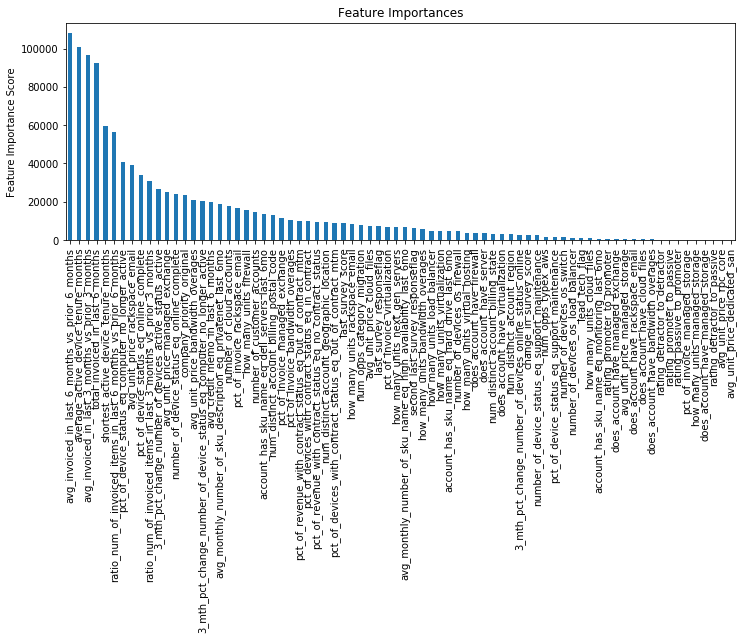

avg_invoiced_in_last_6_months_vs_prior_6_months    108168
average_active_device_tenure_months                100627
avg_invoiced_in_last_3_months_vs_prior_3_months     96764
total_invoiced_in_last_6_months                     92658
shortest_active_device_tenure_months                59331
dtype: int64
Confusion matrix for evaluation data:
 [[37473  2394]
 [  495  1648]]
Precision-Specificity 
 0.40771895101434935
Recall-Sensitivity 
 0.7690153989734018
F 2 Score 
 0.6532424290470905


Accuracy:
0.9312306593668174



Model Fit End time
2020-04-29 19:19:51

Model Fit Start time
2020-04-29 19:19:51




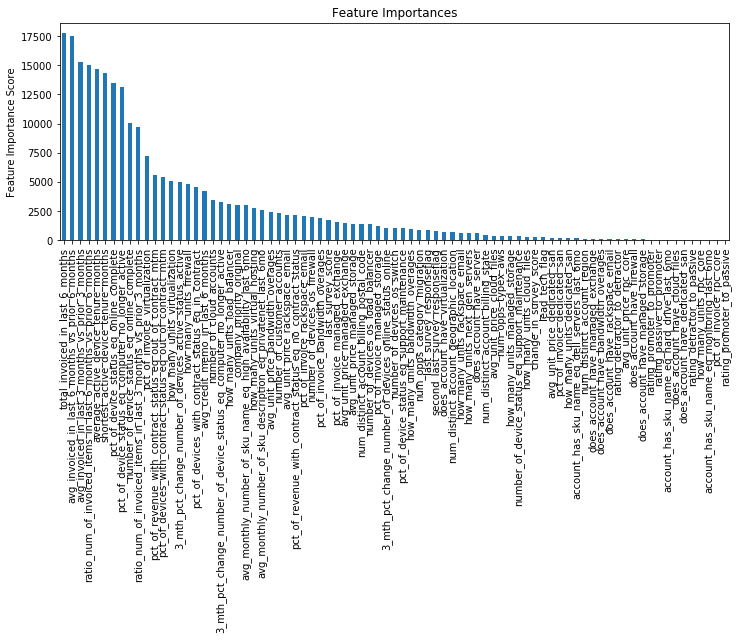

total_invoiced_in_last_6_months                                   17776
avg_invoiced_in_last_6_months_vs_prior_6_months                   17546
avg_invoiced_in_last_3_months_vs_prior_3_months                   15309
ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    15049
average_active_device_tenure_months                               14695
dtype: int64
Confusion matrix for evaluation data:
 [[10308   951]
 [  295   713]]
Precision-Specificity 
 0.4284855769230769
Recall-Sensitivity 
 0.7073412698412699
F 2 Score 
 0.625877808988764


Accuracy:
0.8984266731882286



Model Fit End time
2020-04-29 19:21:58

Model Fit Start time
2020-04-29 19:21:58




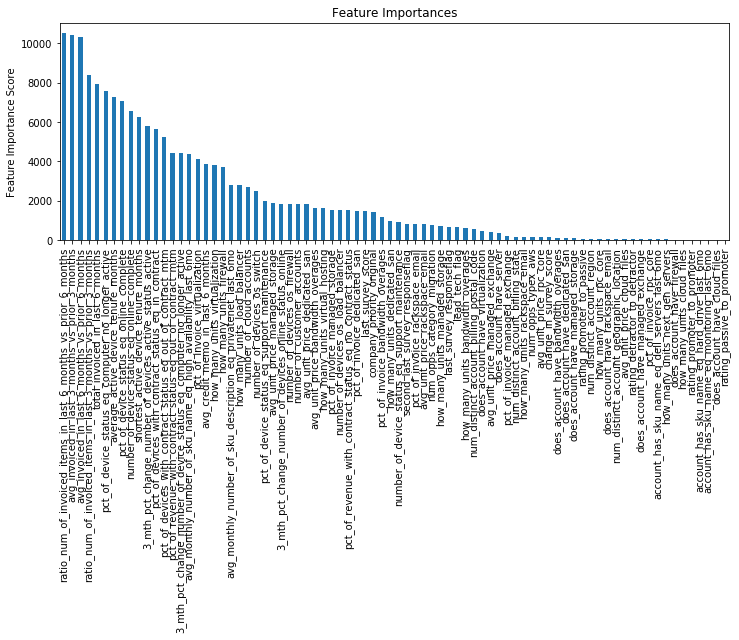

ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    10532
avg_invoiced_in_last_3_months_vs_prior_3_months                   10438
avg_invoiced_in_last_6_months_vs_prior_6_months                   10342
ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months     8386
total_invoiced_in_last_6_months                                    7954
dtype: int64
Confusion matrix for evaluation data:
 [[3256  540]
 [ 125  327]]
Precision-Specificity 
 0.3771626297577855
Recall-Sensitivity 
 0.7234513274336283
F 2 Score 
 0.6112149532710279


Accuracy:
0.8434557438794726



Model Fit End time
2020-04-29 19:23:01


In [11]:
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_hard_drive_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'average_active_device_tenure_months'
,'avg_credit_memo_in_last_6_months'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_monthly_number_of_sku_description_eq_privatenet_last_6mo'
,'avg_monthly_number_of_sku_name_eq_high_availability_last_6mo'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'company_priority_original'
,'does_account_have_bandwidth_overages'
,'does_account_have_cloud_files'
,'does_account_have_dedicated_san'
,'does_account_have_firewall'
,'does_account_have_managed_exchange'
,'does_account_have_managed_storage'
,'does_account_have_rackspace_email'
,'does_account_have_server'
,'does_account_have_virtualization'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_files'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_responseflag'
,'last_survey_score'
,'lead_tech_flag'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_geographic_location'
,'num_distinct_account_region'
,'num_opps_category_migration'
,'num_opps_typex_aws'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'pct_of_device_status_eq_computer_no_longer_active'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_dedicated_san'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_virtualization'
,'pct_of_revenue_with_contract_status_eq_no_contract_status'
,'pct_of_revenue_with_contract_status_eq_out_of_contract_mtm'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'rating_promoter_to_promoter'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'second_last_survey_responseflag'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

include_col_mid = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_hard_drive_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'average_active_device_tenure_months'
,'avg_credit_memo_in_last_6_months'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_monthly_number_of_sku_description_eq_privatenet_last_6mo'
,'avg_monthly_number_of_sku_name_eq_high_availability_last_6mo'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'company_priority_original'
,'does_account_have_bandwidth_overages'
,'does_account_have_cloud_files'
,'does_account_have_dedicated_san'
,'does_account_have_firewall'
,'does_account_have_managed_exchange'
,'does_account_have_managed_storage'
,'does_account_have_rackspace_email'
,'does_account_have_server'
,'does_account_have_virtualization'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_files'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_responseflag'
,'last_survey_score'
,'lead_tech_flag'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_geographic_location'
,'num_distinct_account_region'
,'num_opps_category_migration'
,'num_opps_typex_aws'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'pct_of_device_status_eq_computer_no_longer_active'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_dedicated_san'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_virtualization'
,'pct_of_revenue_with_contract_status_eq_no_contract_status'
,'pct_of_revenue_with_contract_status_eq_out_of_contract_mtm'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'rating_promoter_to_promoter'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'second_last_survey_responseflag'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
       
]

include_col_hi = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_hard_drive_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'average_active_device_tenure_months'
,'avg_credit_memo_in_last_6_months'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_monthly_number_of_sku_description_eq_privatenet_last_6mo'
,'avg_monthly_number_of_sku_name_eq_high_availability_last_6mo'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'company_priority_original'
,'does_account_have_bandwidth_overages'
,'does_account_have_cloud_files'
,'does_account_have_dedicated_san'
,'does_account_have_firewall'
,'does_account_have_managed_exchange'
,'does_account_have_managed_storage'
,'does_account_have_rackspace_email'
,'does_account_have_server'
,'does_account_have_virtualization'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_files'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_responseflag'
,'last_survey_score'
,'lead_tech_flag'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_geographic_location'
,'num_distinct_account_region'
,'num_opps_category_migration'
,'num_opps_typex_aws'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'pct_of_device_status_eq_computer_no_longer_active'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_dedicated_san'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_virtualization'
,'pct_of_revenue_with_contract_status_eq_no_contract_status'
,'pct_of_revenue_with_contract_status_eq_out_of_contract_mtm'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'rating_promoter_to_promoter'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'second_last_survey_responseflag'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")


xgb_final_low = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=0, 
        learning_rate=0.02,
        max_delta_step=2, 
        max_depth=14, 
        min_child_weight=0, 
        missing=None,
        n_estimators=2000, 
#        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_mid = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.8,
        gamma=0, 
        learning_rate=0.01,
        max_delta_step=1, 
        max_depth=11, 
        min_child_weight=1, 
        missing=None,
        n_estimators=2000, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        subsample=0.7,
        verbosity=0,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_hi = XGBClassifier(
        base_score=0.5, 
        booster='gbtree', 
        colsample_bylevel=1,
        colsample_bytree=0.7, 
        eval_metric='auc', 
        gamma=0,
        learning_rate=0.005, 
        max_delta_step=0, 
        max_depth=13, 
        max_features=13,
        min_child_weight=1, 
        missing=None, 
        n_estimators=1500, 
        n_jobs=1,
        nthread=-1, 
        objective='binary:logistic', 
#        random_state=seed,
        reg_alpha=0.1, 
        reg_lambda=1e-05, 
        scale_pos_weight=1, 
        silent=True, 
        subsample=0.8
        )

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)

#inital model run:
#F2: .517, .577, .667 (L, M, H) Acc:  (L, M, H) - random seed 
#F2: .665, .644, .666 (L, M, H) Acc: .943, .913, .869 (L, M, H) - random seed 
#F2: .664, .618, .663 (L, M, H) Acc: .939, .892, .888 (L, M, H) - random seed 
#F2: .664, .618, .663 (L, M, H) Acc: .939, .892, .888 (L, M, H) - random seed 
#F2: .645, .646, .592 (L, M, H) Acc: .943, .910, .850 (L, M, H) - random seed (diff months)
#F2: .646, .657, .574 (L, M, H) Acc: .944, .914, .848 (L, M, H) - random seed (diff months)

#F2 scores with basic gridsearch on n_estimators and learning_rate: .517, .577, .667 (L, M, H)
#F2 scores with basic gridsearch on n_estimators and learning_rate: .518, .567, .659 (L, M, H)

#20 Nov 19 run with full feature list vs reduced list (about 1/2 of features, and all ticketing features taken out)
#F2 .695, .658, .616 (L, M, H)
#F2 .687, .660, .627 (L, M, H) (reduced feature list)
#Accuracy .947, .915, .867 (L, M, H)
#Accuracy .944, .915, .893 (L, M, H) (reduced feature list)

#29 Apr 20 run with full feature list vs reduced list (about 1/2 of features, and all ticketing features taken out)
#F2 .664, .628, .610 (L, M, H)
#F2 .653, .626, .611 (L, M, H) (reduced feature list)
#Accuracy .939, .907, .863 (L, M, H)
#Accuracy .931, .898, .843 (L, M, H) (reduced feature list)


In [12]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split
#re-run for the first iteration of eliminated features
fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[True]).copy()
fi_low_gain.to_excel('2feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[True]).copy()
fi_mid_gain.to_excel('2feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[True]).copy()
fi_hi_gain.to_excel('2feat_imp_hi.xlsx')


train ready
eval ready

Model Fit Start time
2020-04-29 19:53:50




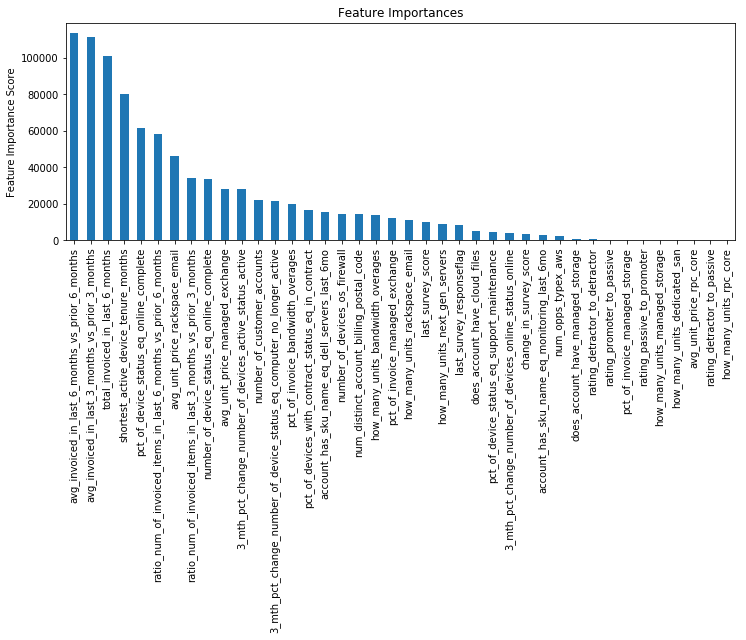

avg_invoiced_in_last_6_months_vs_prior_6_months    113664
avg_invoiced_in_last_3_months_vs_prior_3_months    111647
total_invoiced_in_last_6_months                    100803
shortest_active_device_tenure_months                80221
pct_of_device_status_eq_online_complete             61437
dtype: int64
Confusion matrix for evaluation data:
 [[37066  2801]
 [  469  1674]]
Precision-Specificity 
 0.3740782122905028
Recall-Sensitivity 
 0.7811479234717685
F 2 Score 
 0.6415267877673029


Accuracy:
0.9221613901452035



Model Fit End time
2020-04-29 19:57:39

Model Fit Start time
2020-04-29 19:57:39




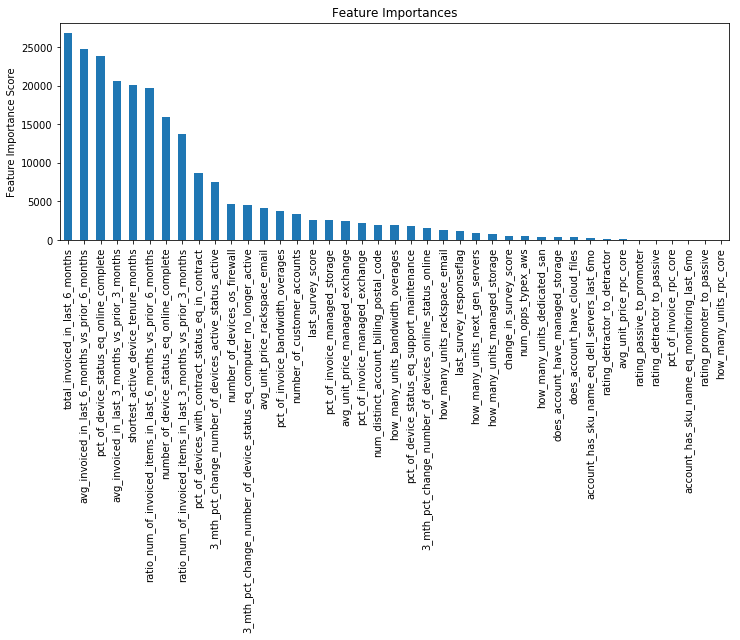

total_invoiced_in_last_6_months                    26835
avg_invoiced_in_last_6_months_vs_prior_6_months    24705
pct_of_device_status_eq_online_complete            23808
avg_invoiced_in_last_3_months_vs_prior_3_months    20652
shortest_active_device_tenure_months               20105
dtype: int64
Confusion matrix for evaluation data:
 [[10233  1026]
 [  280   728]]
Precision-Specificity 
 0.4150513112884835
Recall-Sensitivity 
 0.7222222222222222
F 2 Score 
 0.6291047355686139


Accuracy:
0.8935355017526697



Model Fit End time
2020-04-29 19:59:24

Model Fit Start time
2020-04-29 19:59:24




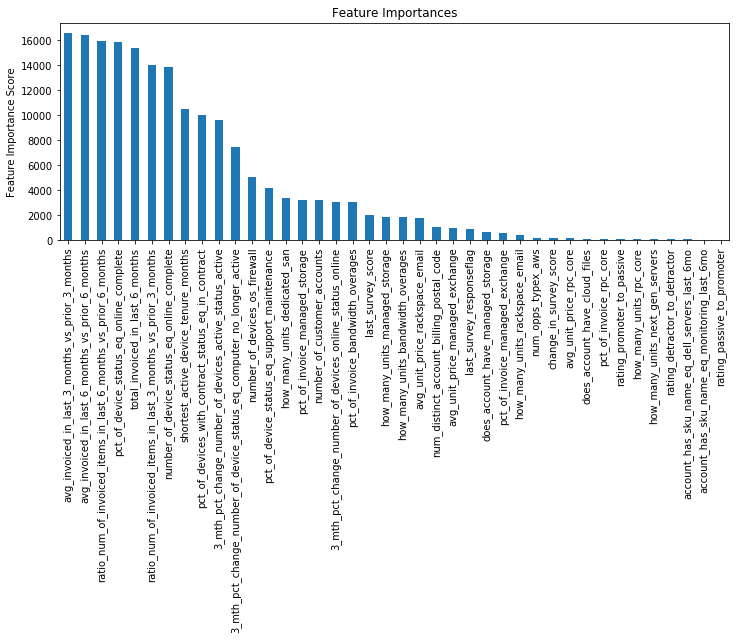

avg_invoiced_in_last_3_months_vs_prior_3_months                   16579
avg_invoiced_in_last_6_months_vs_prior_6_months                   16379
ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    15920
pct_of_device_status_eq_online_complete                           15828
total_invoiced_in_last_6_months                                   15345
dtype: int64
Confusion matrix for evaluation data:
 [[3226  570]
 [ 122  330]]
Precision-Specificity 
 0.36666666666666664
Recall-Sensitivity 
 0.7300884955752213
F 2 Score 
 0.6093057607090103


Accuracy:
0.8370998116760828



Model Fit End time
2020-04-29 20:00:25


In [13]:
#2nd round of elimination
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_bandwidth_overages'
,'how_many_units_dedicated_san'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_responseflag'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opps_typex_aws'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
               ]

include_col_mid = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_bandwidth_overages'
,'how_many_units_dedicated_san'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_responseflag'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opps_typex_aws'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

include_col_hi = [
'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_dell_servers_last_6mo'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_bandwidth_overages'
,'how_many_units_dedicated_san'
,'how_many_units_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_responseflag'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opps_typex_aws'
,'number_of_customer_accounts'
,'number_of_device_status_eq_online_complete'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)

#29 Apr 20 run with full feature list vs twice reduced list
#F2 .664, .628, .610 (L, M, H)
#F2 .642, .629, .609 (L, M, H) (twice reduced feature list)
#Accuracy .939, .907, .863 (L, M, H)
#Accuracy .922, .894, .837 (L, M, H) (twice reduced feature list)

In [14]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split
#re-run for the second iteration of eliminated features
fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[False]).copy()
fi_low_gain.to_excel('3feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[False]).copy()
fi_mid_gain.to_excel('3feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[False]).copy()
fi_hi_gain.to_excel('3feat_imp_hi.xlsx')


train ready
eval ready

Model Fit Start time
2020-06-02 21:26:29




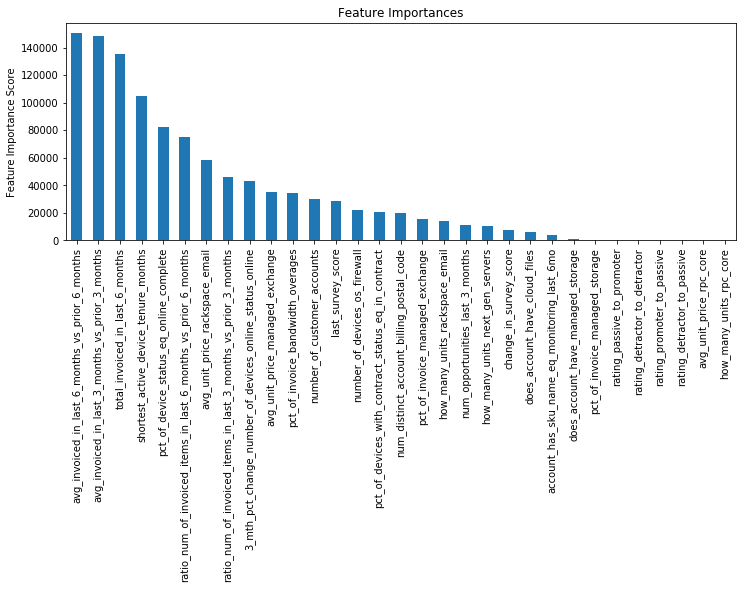

avg_invoiced_in_last_6_months_vs_prior_6_months    150385
avg_invoiced_in_last_3_months_vs_prior_3_months    148147
total_invoiced_in_last_6_months                    135690
shortest_active_device_tenure_months               104696
pct_of_device_status_eq_online_complete             82424
dtype: int64
Confusion matrix for evaluation data:
 [[36947  2920]
 [  479  1664]]
Precision-Specificity 
 0.36300174520069806
Recall-Sensitivity 
 0.7764815678954736
F 2 Score 
 0.6324110671936759


Accuracy:
0.9190906926922161



Model Fit End time
2020-06-02 21:30:21

Model Fit Start time
2020-06-02 21:30:21




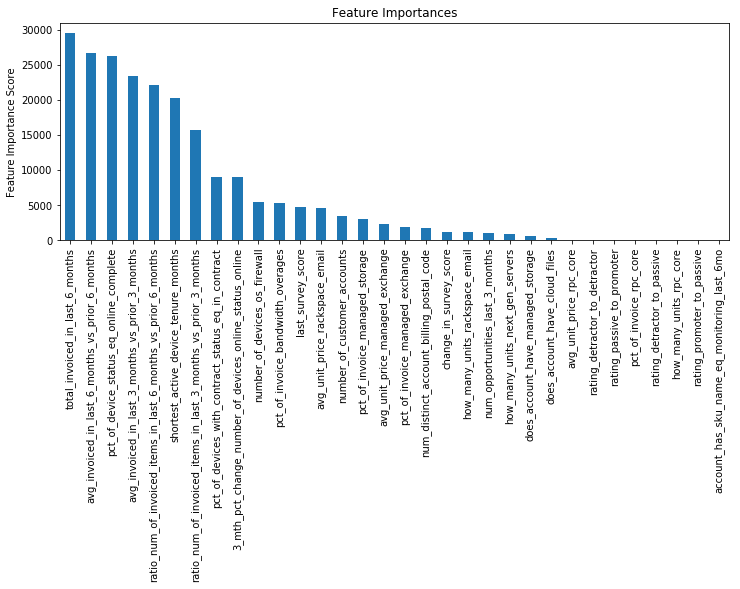

total_invoiced_in_last_6_months                                   29518
avg_invoiced_in_last_6_months_vs_prior_6_months                   26704
pct_of_device_status_eq_online_complete                           26356
avg_invoiced_in_last_3_months_vs_prior_3_months                   23386
ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    22117
dtype: int64
Confusion matrix for evaluation data:
 [[10156  1103]
 [  284   724]]
Precision-Specificity 
 0.39627805145046524
Recall-Sensitivity 
 0.7182539682539683
F 2 Score 
 0.6178528759173921


Accuracy:
0.8869324203146653



Model Fit End time
2020-06-02 21:31:40

Model Fit Start time
2020-06-02 21:31:40




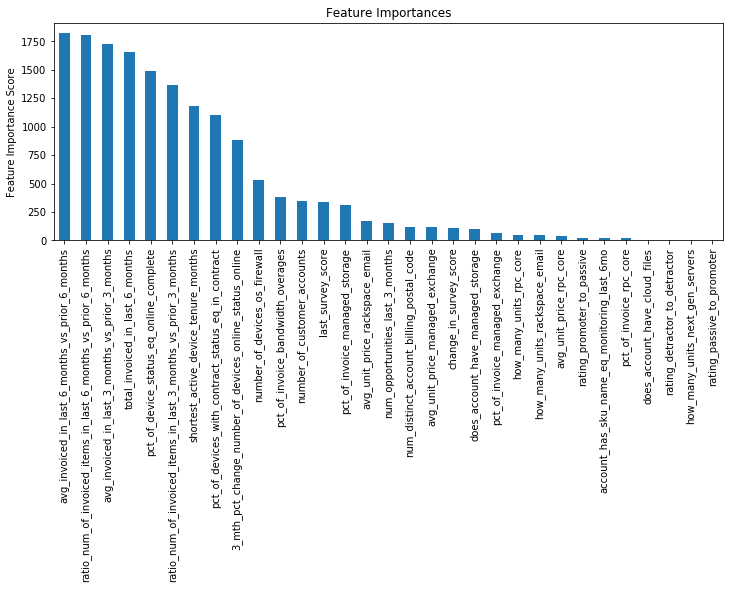

avg_invoiced_in_last_6_months_vs_prior_6_months                   1820
ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months    1804
avg_invoiced_in_last_3_months_vs_prior_3_months                   1728
total_invoiced_in_last_6_months                                   1659
pct_of_device_status_eq_online_complete                           1488
dtype: int64
Confusion matrix for evaluation data:
 [[3127  669]
 [ 100  352]]
Precision-Specificity 
 0.34476003917727716
Recall-Sensitivity 
 0.7787610619469026
F 2 Score 
 0.6221279604100388


Accuracy:
0.8189736346516008



Model Fit End time
2020-06-02 21:31:43


In [13]:
#3rd round of elimination
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
'3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opportunities_last_3_months'
,'number_of_customer_accounts'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'

,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
               ]

include_col_mid = [

    '3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opportunities_last_3_months'
,'number_of_customer_accounts'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'

,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

include_col_hi = [

    '3_mth_pct_change_number_of_devices_online_status_online'
,'account_has_sku_name_eq_monitoring_last_6mo'
,'avg_invoiced_in_last_3_months_vs_prior_3_months'
,'avg_invoiced_in_last_6_months_vs_prior_6_months'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'change_in_survey_score'
,'does_account_have_cloud_files'
,'does_account_have_managed_storage'
,'how_many_units_next_gen_servers'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'last_survey_score'
,'num_distinct_account_billing_postal_code'
,'num_opportunities_last_3_months'
,'number_of_customer_accounts'
,'number_of_devices_os_firewall'
,'pct_of_device_status_eq_online_complete'

,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rpc_core'
,'rating_detractor_to_detractor'
,'rating_detractor_to_passive'
,'rating_passive_to_promoter'
,'rating_promoter_to_passive'
,'ratio_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'shortest_active_device_tenure_months'
,'total_invoiced_in_last_6_months'
]

#'3_mth_pct_change_number_of_devices_active_status_active'
#,
#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)
#636,618,610 (opps typex aws) -> 640,618,614 (num opps last 12) -> 640,620,606 (num opps last 6) -> 635,620,613
#29 Apr 20 run with full feature list vs twice reduced list
#F2 .664, .628, .610 (L, M, H)
#F2 .631, .612, .601 (L, M, H) (3x reduced feature list)
#Accuracy .939, .907, .863 (L, M, H)
#Accuracy .919, .885, .812 (L, M, H) (3x reduced feature list)

#removed pct_of_device_status_eq_support_maintenance
#F2 .629, .616, .619 (L, M, H) 
#Accuracy .917, .886, .830 (L, M, H)

#removed just 3_mth_pct_change_number_of_devices_active_status_active
#F2 .629, .610, .615 (L, M, H) 
#Accuracy .917, .885, .831 (L, M, H)

#removed both pct_of_device_status_eq_support_maintenance and 3_mth_pct_change_number_of_devices_active_status_active
#F2 .628, .611, .605 (L, M, H) 
#Accuracy .917, .885, .827 (L, M, H)



In [ ]:
#rerun again but just use hi rev feature list, for simplicity, and see how results come out

In [ ]:
#3rd round of elimination
#based on list of features with gain <3.0 for each revenue band, eliminate those features from the dataset by rev band, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

include_col = [

               ]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================

seed = 17

dedicated_train_low_rus = p.AndrewsRandomUnderSampler(dedicated_train_low, 'target', seed)
dedicated_train_mid_rus = p.AndrewsRandomUnderSampler(dedicated_train_mid, 'target', seed)
dedicated_train_hi_rus = p.AndrewsRandomUnderSampler(dedicated_train_hi, 'target', seed)


print('Minority class resampling complete')

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

In [ ]:
#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=13,
              max_features=13, min_child_weight=1, missing=None,
              n_estimators=555, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=0, reg_alpha=0.1,
              reg_lambda=1e-05, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.8, verbosity=1)

feature importance chart - hi


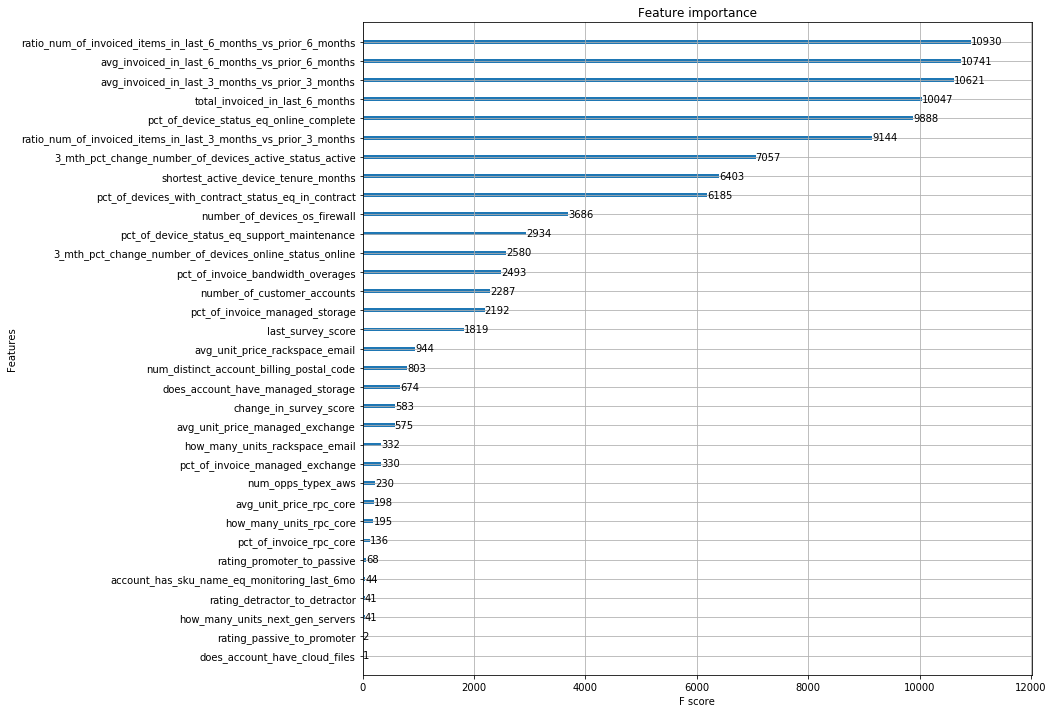

feature importance chart- gain


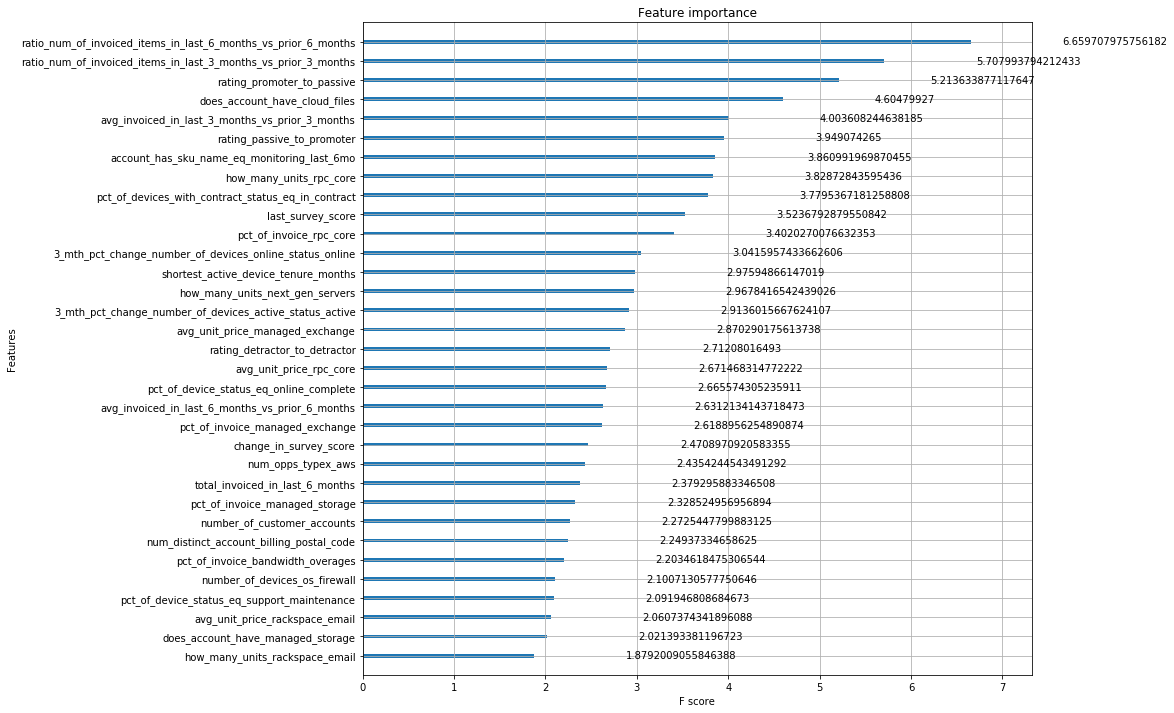

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0, learning_rate=0.01, max_delta_step=1, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=1655, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=0)

feature importance chart - mid


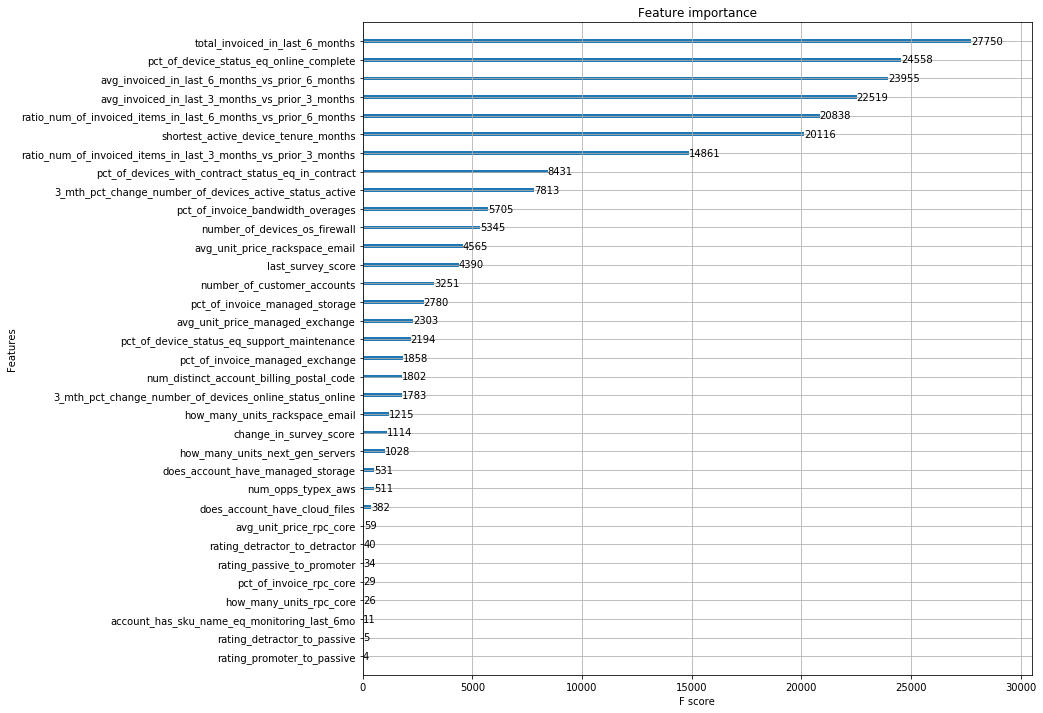

feature importance chart- gain


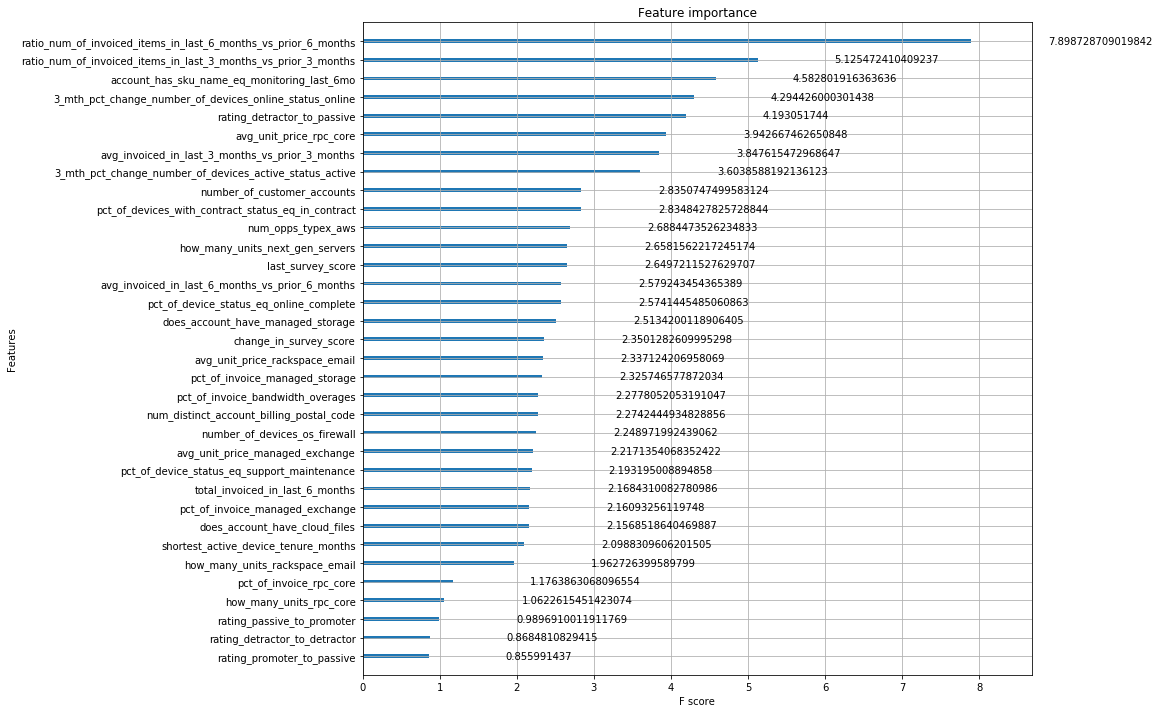

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0, learning_rate=0.02, max_delta_step=2, max_depth=14,
              min_child_weight=0, missing=None, n_estimators=1261, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.7, verbosity=1)

feature importance chart - low


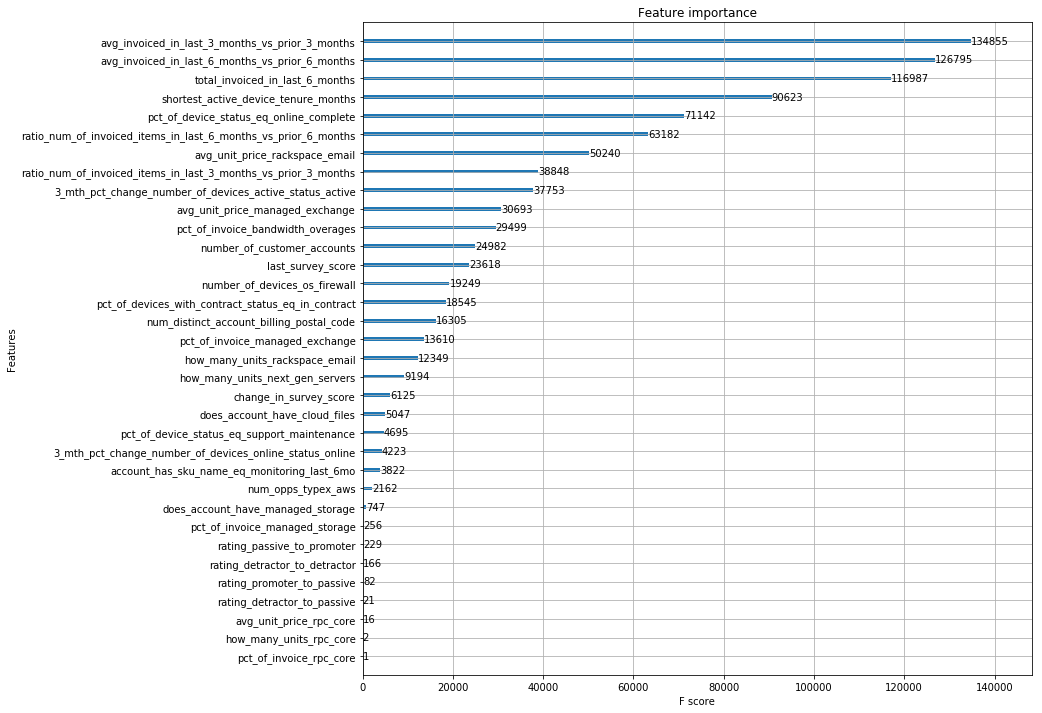

feature importance chart- gain


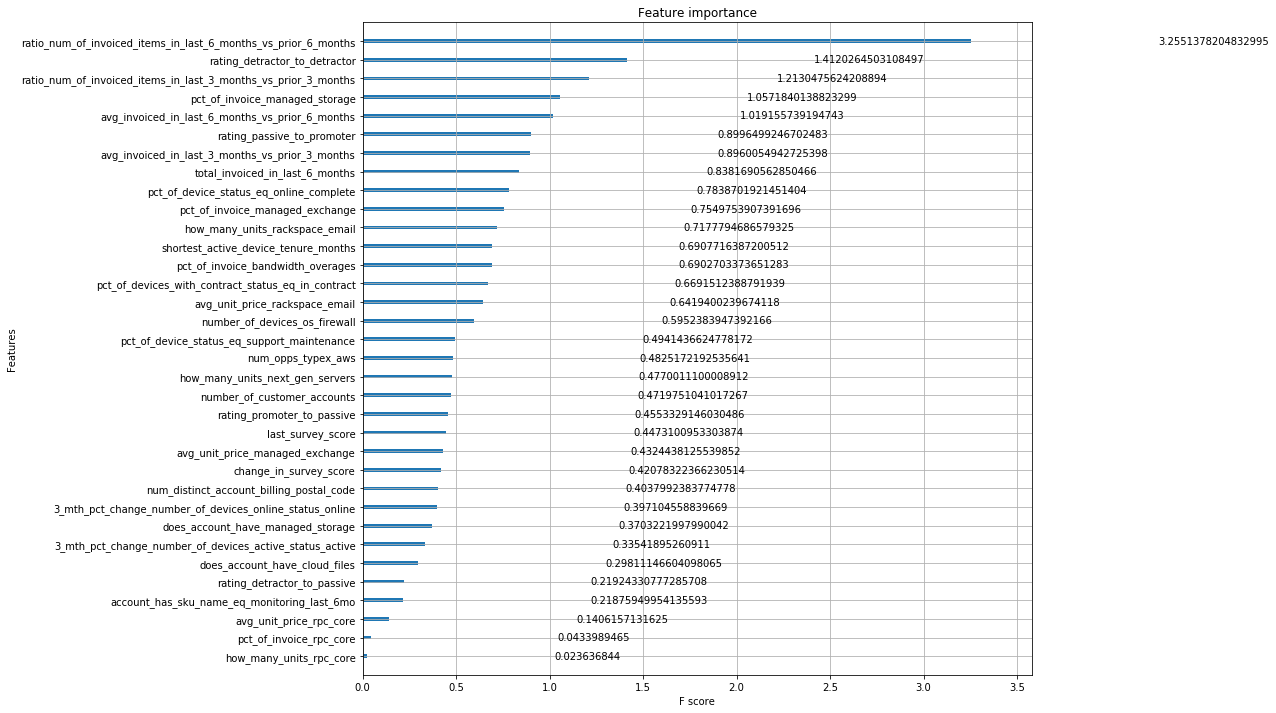

In [22]:
# create most recent feature importance plot for latest model : gbm_final_low, gbm_final_mid, gbm_final_hi
import matplotlib.pyplot as pyplot
from xgboost import plot_importance

rcParams['figure.figsize'] = 12, 12
fi_low = pd.concat([pd.DataFrame(predictors_low),pd.DataFrame(xgb_final_low.feature_importances_)], axis=1)
fi_low.columns=['features','feature importance']
fi_mid = pd.concat([pd.DataFrame(predictors_mid),pd.DataFrame(xgb_final_mid.feature_importances_)], axis=1)
fi_mid.columns=['features','feature importance']
fi_hi = pd.concat([pd.DataFrame(predictors_hi),pd.DataFrame(xgb_final_hi.feature_importances_)], axis=1)
fi_hi.columns=['features','feature importance']


# High Value Accounts
#print(fi_hi)
print(xgb_final_hi)

print('\nfeature importance chart - hi')
plot_importance(xgb_final_hi)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_hi, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_hi, importance_type="gain")
pyplot.show()

#Mid Value Accounts
#print(fi_mid)
print(xgb_final_mid)

print('\nfeature importance chart - mid')
plot_importance(xgb_final_mid)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_mid, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_mid, importance_type="gain")
pyplot.show()

#Low Value Accounts
#print(fi_low)
print(xgb_final_low)

import matplotlib.pyplot as pyplot

print('\nfeature importance chart - low')
plot_importance(xgb_final_low)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_low, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_low, importance_type="gain")
pyplot.show()

In [13]:
#==============================================================================================================
import shap

#load JS Visualization code 
shap.initjs()

In [23]:
#Explain the Model's predictions using SHAP values
#High value Accounts
explainer_hi = shap.TreeExplainer(xgb_final_hi)
shap_values_hi = explainer_hi.shap_values(x_eval_hi)
#Mid value Accounts
explainer_mid = shap.TreeExplainer(xgb_final_mid)
shap_values_mid = explainer_mid.shap_values(x_eval_mid)
#Low value Accounts
explainer_low = shap.TreeExplainer(xgb_final_low)
shap_values_low = explainer_low.shap_values(x_eval_low)


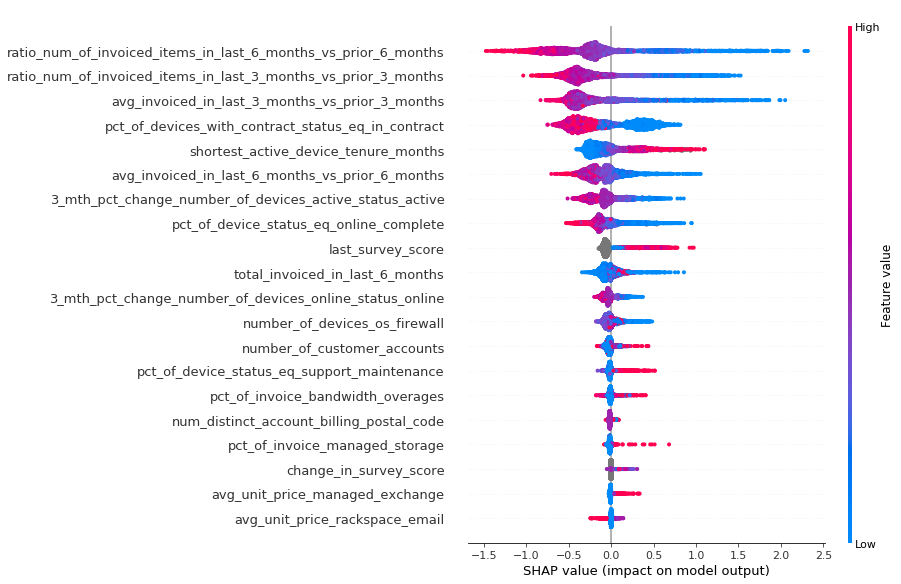

In [24]:
shap.summary_plot(shap_values_hi, x_eval_hi)

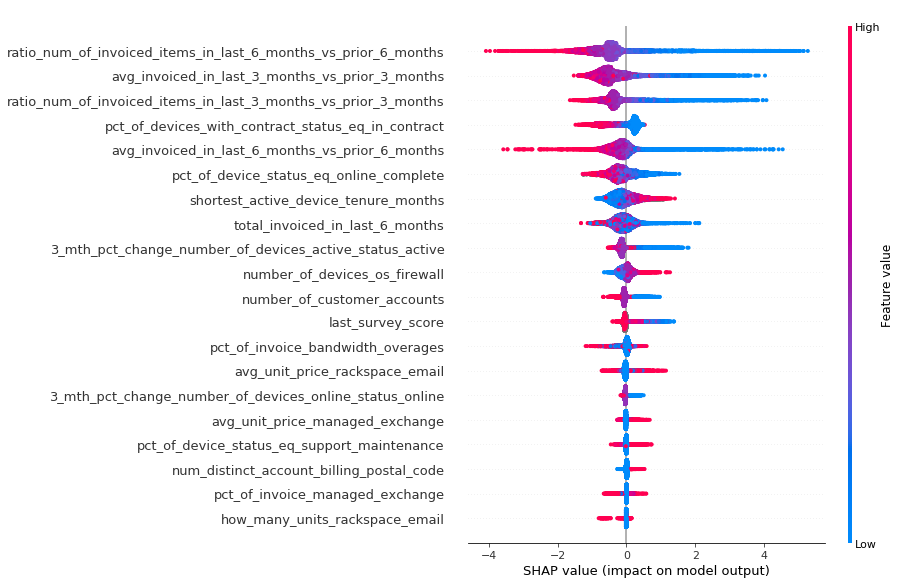

In [25]:
shap.summary_plot(shap_values_mid, x_eval_mid)

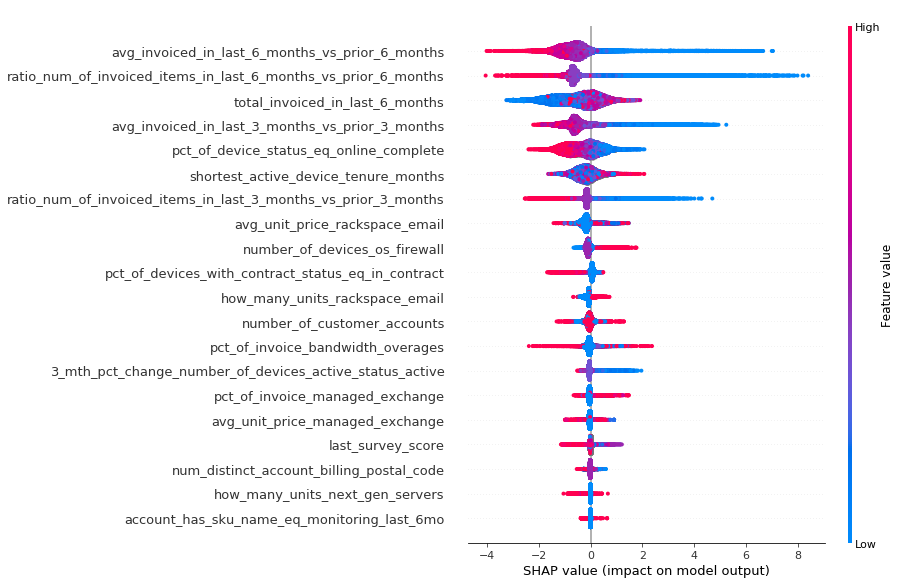

In [26]:
shap.summary_plot(shap_values_low, x_eval_low)


Dependence plot- hi rev accounts


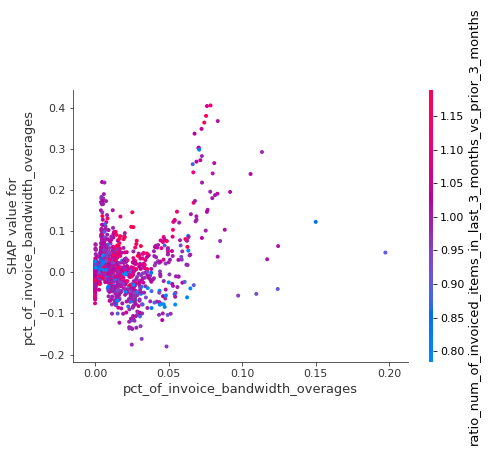


Dependence plot- mid rev accounts


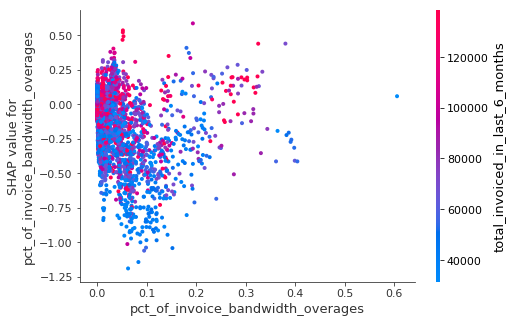


Dependence plot- low rev accounts


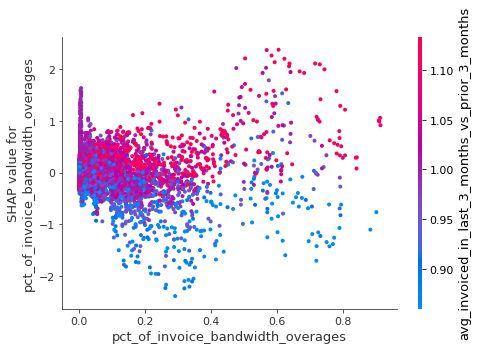

In [32]:
# SHAP interaction plots - the variable for the colored scale is automatically selected
base_col = 'pct_of_invoice_bandwidth_overages'

print("\nDependence plot- hi rev accounts")
shap.dependence_plot(base_col, shap_values_hi, x_eval_hi)
print("\nDependence plot- mid rev accounts")
shap.dependence_plot(base_col, shap_values_mid, x_eval_mid)
print("\nDependence plot- low rev accounts")
shap.dependence_plot(base_col, shap_values_low, x_eval_low)

In [ ]:
from xgboost import plot_tree
plot_tree(xgb_final_hi) #this feature won't work if white spaces are in the feature names.. which are in almost all of them